In [23]:
# Version 2.2 (automated removal experiments) - new PN Activity representation (binomial dist.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pickle
import scipy.stats as st
import copy

# read csv 
df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FUNCTIONS

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# normalizes weights by the row's sum in a pandas df
def normalize_kc_weights_df(df, sum_of_w):
    row = len(df.index)
    for r in range(row):
        w = df.iloc[r]
        s = sum(abs(w)) # sum of row
        if (s != 0):
            df.iloc[r] = [i/s for i in w]
    return sum_of_w * df

# normalizes weights by the row's sum in a numpy array
def normalize_kc_weights_np(arr, sum_of_w):
    row = len(arr)
    for r in range(row):
        w = arr[r]
        s = sum(abs(w)) # sum of row
        if (s != 0):
            arr[r] = [i/s for i in w]
    return sum_of_w * arr

# transforms weight matrix into doubly stochastic matrix (rows and columns both sum to 1)
def transform_doubly_stochastic_df(df):
    row = len(df.index)
    col = len(df.columns)
    tol = 0.005
    done = False
    sum_r = np.zeros(row)
    sum_c = np.zeros(col)
    while not done:
        # normalize rows if not equal to 1
        for r in range(row):
            w = df.iloc[r]
            s = sum(abs(w)) # sum of row
            if (s != 0):
                df.iloc[r] = [i/s for i in w]
        sum_r = df.sum(axis=1)
        c1 = np.all(abs(sum_r - 1) <= tol)
                
        # normalize columns if not equal to 1
        for c in range(col):
            w = df.iloc[:,c]
            s = sum(abs(w)) # sum of column
            if (s != 0):
                df.iloc[:,c] = [i/s for i in w]
        sum_c = df.sum(axis=0)
        c2 = np.all(abs(sum_c - 1) <= tol)
            
        if c1 == True and c2 == True:
            done = True

# Sets the bias for a single KC so that the KC fires 5% of 
# the time in response to any odor
# inputs - array of all points from all odors
# weights - array of weights (aka synapses) for a single KC
def set_kc_bias(inputs, weights):
    I = len(inputs)
    bias = 0
    
    kc_output = np.zeros((I,)) # array to store output values
    
    # loops thru all inputs and calculates and stores the KC output value
    for i in range(I):
        point = inputs[i]
        #print("point:\n{}, length: {}".format(point, len(point)))

        # equation
        x = np.dot(point, weights) # no bias yet (theta=0)
        #print("output value: {}".format(x))

        kc_output[i] = x  # add output value to output array
    
    kc_output.sort() # sort output values in ascending order
    #print("output values of single KC after sorting:\n{} \nlength: {}".format(kc_output, len(kc_output)))
    idx = int(0.05 * len(kc_output)) # getting index for the threshold that'll provide a 5% firing rate (out of 5000, this is the 251th output value with index of 250)
    #print("index: ", idx)
    bias = kc_output[idx]
    #print("bias: ", bias)
    
    return bias

# Calculates output of KC layer
# weights - weights (num of synapses) for connections from PNs to KCs
# biases - biases
# inputs - inputs from PNs
def build_pn_to_kc(inputs, weights, biases):
    
    # equation
    x1 = np.dot(inputs, weights) + biases # matrix multiplication to multiply inputs by weights
    #print("after matrix multiplication:\n{}, \nlength: {}".format(x1, len(x1)))

    # thresholding
    x1 = np.where(x1 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x1, len(x1)))
    
    return x1

# Calculates output of MBON layer
# weights - weights (num of synapses) from KC to MBON
# inputs - inputs from KCs
# bias - biases
def build_kc_to_mbon(inputs, weights, bias):
    
    # equation
    x2 = np.dot(inputs, weights) + bias
    #print("after matrix multiplication:\n{}, \nnum of rows: {}".format(x2, len(x2)))

    # thresholding
    x2 = np.where(x2 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x2, len(x2)))
    
    return x2

# Randomly prunes a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def prune_rand_kcs(df, num):
    num_mbons = len(df.columns)
    kc_names = []
    
    # loop thru each column = MBON
    for m in range(num_mbons):        
        idxs_with_conn = np.asarray(np.where(df.iloc[:,m] > 0)).flatten() # gets indicies where there is a connection to a KC
        
        # randomly select KC connections to be removed
        s = num
        if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
            s = len(idxs_with_conn)
        indicies = np.random.choice(a=idxs_with_conn, size=s, replace=False)
        
        kc_names.append(df.index[indicies]) # record names of KCs
        
        for i in indicies:
            df.iloc[i, m] = 0
    
    df = df.to_numpy()
    return df, kc_names

# ORIGINAL prune_top_kcs function
# Targeted pruning prunes KC connections for each MBON based on their synaptic weight value
# Returns the new weight table (df) and the names of KCs with connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def prune_top_kcs(prev_w, curr_w, num, run):
    num_mbons = 19
    kc_names = []
#     print(prev_w.shape)
    
    # loop thru each column = MBON
    for m in range(0,num_mbons):
        vals = abs(prev_w[run,:,m]) # absolute value of column
        idxs_with_conn = np.asarray(np.where(vals > 0)).flatten() # gets indicies where there is a connection to a KC
        
        # find KC connections with highest weight values to remove
        s = num
        if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
            s = len(idxs_with_conn)
        top_weight_idx = np.argpartition(vals, -1*s)[-1*s:] # gets indicies of top #num KC connections
        
        kc_names = list(curr_w.index[top_weight_idx]) # names of KC connections pruned
    
#         curr_w = curr_w.to_numpy()
        curr_w.iloc[top_weight_idx, m] = 0 # sets weight values of KC connections to be removed to zero

    return curr_w.to_numpy(), kc_names
        

# Randomly ablates a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def ablate_rand_kcs(df, num):
    num_mbons = len(df.columns)
    num_kcs = len(df)   
        
    # randomly select KC connections to be removed
    indicies = random.choice(num_kcs, size=num, replace=False)
    kc_names = list(df.index[indicies]) # record names of KCs
    # sets each row (= each KC) in indices to zero
    for i in indicies:
        df.iloc[i, :] = 0
    
    df = df.to_numpy()
    return df, kc_names

# Sets the all synaptic weight values of the top certain number of KCs to zero. Returns new weight table with
# KCs removed and a list of names of the KCs removed
# prev_w - weight table from previous run (np arr)
# curr_w - current weight table (df as input, return as np array)
# num - the number of KCs' connections to remove
# run - the realization (eg. 0, 1, 2...)
def ablate_top_kcs(prev_w, curr_w, num, run):
    sum_weights = abs(prev_w[run]).sum(axis=1) # total absolute value of final weights for each KC 
    top_weight_idx = np.argpartition(sum_weights, -1*num)[-1*num:]
    
    # record which KCs are removed
    kc_names = list(curr_w.index[top_weight_idx])
    
    curr_w = curr_w.to_numpy()
    curr_w[top_weight_idx,:] = 0 # sets weight values of KCs to be removed to zero
    
    return curr_w, kc_names

# Sets the all synaptic weight values of the top certain number (relative to the number of connections) of KCs to zero. Returns new weight table with
# KCs removed and a list of names of the KCs removed
# prev_w - weight table from previous run (np arr)
# curr_w - current weight table (df as input, return as np array)
# num - the number of KCs' connections to remove
# run - the realization (eg. 0, 1, 2...)
def ablate_top_kcs_rel(prev_w, curr_w, num, run, kc_mbon):
    sum_weights = abs(prev_w[run]).sum(axis=1) # total absolute value of final weights for each KC 
    num_nonzeros = (kc_mbon != 0).astype(int).sum(axis=1)
    rel_sum_weights = sum_weights.astype(float) / num_nonzeros.astype(float)
    top_weight_idx = np.argpartition(rel_sum_weights, -1*num)[-1*num:]
    
    # record which KCs are removed
    kc_names = list(curr_w.index[top_weight_idx])
    
    curr_w = curr_w.to_numpy()
    curr_w[top_weight_idx,:] = 0 # sets weight values of KCs to be removed to zero
    
    return curr_w, kc_names

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
R = 20 # number of realizations of training
K = 23 # number of KC removal sets
T = 5000

# color palette (19 colors)
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson', 'mediumpurple', 'rosybrown', 
          'pink', 'goldenrod', 'darkturquoise', 'thistle', 'lightsteelblue', 'peachpuff', 
          'lightgreen', 'lightsalmon', 'sienna', 'orchid', 'gray', 'khaki', 'lightblue']

# dictionary of colors for each of 7 KC types
kc_color = {
    "1 claw KC left": 'steelblue',
    "2 claw KC left": 'darkorange',
    "3 claw KC left": 'forestgreen',
    "4 claw KC left": 'crimson',
    "5 claw KC left": 'mediumpurple',
    "6 claw KC left": 'rosybrown',
    "young KC left": 'pink'
}

names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', 
         '6 claw KC left', 'young KC left']

In [24]:
# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)

pn_kc

,1 claw KC left,1 claw KC left.1,1 claw KC left.2,1 claw KC left.3,1 claw KC left.4,1 claw KC left.5,1 claw KC left.6,1 claw KC left.7,1 claw KC left.8,1 claw KC left.9,...,young KC left.27,young KC left.28,young KC left.29,young KC left.30,young KC left.31,young KC left.32,young KC left.33,young KC left.34,young KC left.35,young KC left.36
Presynaptic PNs,,,,,,,,,,,,,,,,,,,,,
1a PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.060606,...,0,0,0,0.0,0.0,1.0,0,0.0,0.0,0
13a PN left,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,1.0,0.0,0.0,0,0.0,0.0,0
22c PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0
24a PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0
30a PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0
33a PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0
35a PN bilateral left,0.0,0.0,0.0,0.0,0.894737,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0
42a PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0
42b PN left,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0


In [40]:
# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

kc_mbon

,MBON-a1 left,MBON-a2 left,MBON-b1 left,MBON-b2 left,MBON-c1 left,MBON-d1 left,MBON-e1 left,MBON-e2 left,MBON-g1 left,MBON-g2 left,MBON-h1 left,MBON-h2 left,MBON-i1 left,MBON-k1 left,MBON-m1 left,MBON-n1 left,MBON-o1 left,MBON-q1 left,MBON-fict
Presynaptic KCs,,,,,,,,,,,,,,,,,,,
1 claw KC left,0.014286,0.011416,0.036723,0.019663,0.034662,0.024450,0.033386,0.052632,0.015595,0.014894,0.020761,0.025974,0.048128,0.000000,0.028249,0.0,0.031746,0.034965,0.009091
1 claw KC left,0.028571,0.009132,0.042373,0.042135,0.023397,0.031785,0.027027,0.022556,0.031189,0.023404,0.006920,0.018182,0.026738,0.000000,0.000000,0.0,0.031746,0.000000,0.009091
1 claw KC left,0.035714,0.009132,0.028249,0.039326,0.019064,0.022005,0.019078,0.030075,0.021442,0.019149,0.020761,0.023377,0.053476,0.034483,0.011299,0.0,0.031746,0.062937,0.009091
1 claw KC left,0.039286,0.011416,0.067797,0.056180,0.033795,0.022005,0.030207,0.045113,0.025341,0.008511,0.024221,0.036364,0.026738,0.000000,0.016949,0.0,0.000000,0.013986,0.009091
1 claw KC left,0.010714,0.006849,0.033898,0.022472,0.054593,0.034230,0.012719,0.000000,0.007797,0.023404,0.031142,0.018182,0.026738,0.022989,0.028249,0.0,0.000000,0.076923,0.009091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.009091
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.009091
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.009091


In [68]:
for i in range(num_kcs):
    kc_name = kc_mbon.index[i]
    pnkc_sum = pn_kc.iloc[:,i].sum()
    kcmbon_sum = kc_mbon.iloc[i, 0:18].sum()
    
    print(f"{kc_name}: {pnkc_sum}, {kcmbon_sum}")

1 claw KC left: 1.0, 0.4475285809606568
1 claw KC left: 1.0, 0.36515627318258254
1 claw KC left: 1.0, 0.4813137647417326
1 claw KC left: 1.0, 0.45790746097616003
1 claw KC left: 1.0, 0.4108983178786791
1 claw KC left: 1.0, 0.5247341067163441
1 claw KC left: 1.0, 0.4132963510684485
1 claw KC left: 1.0, 0.48957873994908835
1 claw KC left: 1.0, 0.2501879602686638
1 claw KC left: 1.0, 0.7555610240827757
1 claw KC left: 1.0, 0.4116670382050727
1 claw KC left: 1.0, 0.44268093266081177
1 claw KC left: 1.0, 0.4236288113646837
1 claw KC left: 1.0, 0.246720930901582
1 claw KC left: 1.0, 0.29646076798606363
1 claw KC left: 1.0, 0.24323187205331018
1 claw KC left: 1.0, 0.40007947640075064
2 claw KC left: 1.0, 0.3611955394588034
2 claw KC left: 1.0, 0.37590443656451045
2 claw KC left: 1.0, 0.27713268739577607
2 claw KC left: 1.0, 0.4193985250528452
2 claw KC left: 1.0, 0.030941324753723173
2 claw KC left: 1.0, 0.4556134956775577
2 claw KC left: 1.0, 0.44258705600903386
2 claw KC left: 1.0, 0.098258

In [43]:
def get_kc_counts():
    num_kc_types = len(names)
    
    # get counts of each KC type
    kc_counts = np.zeros(num_kc_types)
    for num in range(num_kc_types):
        kc_counts[num] = list(kc_mbon.index).count(names[num])
    return kc_counts

# get the indices of the end of each KC type
def get_kc_indices():
    kc_counts = get_kc_counts() # get the total count of each KC type
    kc_indices = (np.cumsum(kc_counts)).astype(int)
    return kc_indices

# Number of KC Input Connections per KC Type

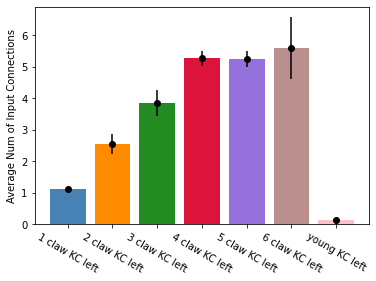

In [53]:
bool_weights = np.where(pn_kc > 0, 1, 0)
num_pn_proj = np.sum(bool_weights, axis=0)

plt.figure()

# find average number of connections for each KC type
kc_indices = get_kc_indices()
num_kc_types = len(kc_indices)
avg_kc_group = np.zeros(num_kc_types)
sem_kc_group = np.zeros(num_kc_types)
start = 0
for idx in range(len(kc_indices)):
    lbl = names[idx]
    end = kc_indices[idx] # end index for kc type
    kc_group = num_pn_proj[start:end] # slice for a kc type
    
    # get mean and standard error of kc type
    avg_kc_group[idx] = np.mean(kc_group)
    sem_kc_group[idx] = st.sem(kc_group)
    start = end # set start index for next kc type
    
# plot
plt.bar(names, avg_kc_group, color=['steelblue', 'darkorange', 'forestgreen', 'crimson', 'mediumpurple', 'rosybrown',
                                    'pink'])
plt.errorbar(names, avg_kc_group, yerr=sem_kc_group, fmt="o", color="black")
plt.ylabel("Average Num of Input Connections")
plt.xticks(rotation = -30)
plt.show()